# Plots for npe-f

In [1]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
import sys
import yaml
from sbi import analysis
import os
from scipy.stats import gaussian_kde
from tqdm import tqdm

NSC_DIR = Path(os.getcwd()).resolve().parent.parent.as_posix()  # NSC dir
sys.path.append(f"{NSC_DIR}/codes/src")
from utils.setup import adapt_path
from utils.event import get_train_valid_lr
from utils.plots import load_img, pairplot, plot_posterior_mapped_samples, marginal_plot
from utils.inference import (
    get_posterior,
    load_stored_config,
    sampling_from_posterior,
    ci_perf_on_dset,
)
from utils.train import WarmupScheduler, plot_posterior_with_label, load_net, get_limits
from simulator.model_sim_pR import DM_sim_for_seqCs_parallel_with_smaller_output
from utils.range import x2seqC, seqC2x, convert_samples_range, convert_array_range

import matplotlib as mpl
import matplotlib.pyplot as plt

# reset matplotlib
# mpl.rcParams.update(mpl.rcParamsDefault)
# # remove top and right axis from plots
# mpl.rcParams["axes.spines.right"] = False
# mpl.rcParams["axes.spines.top"] = False
# # remove all edges

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE, weight='bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams["axes.edgecolor"] = "k"
mpl.rcParams["axes.linewidth"] = 2

font = {"weight": "bold"}
mpl.rc("font", **font)

# grid alpha to 0.2
mpl.rcParams["grid.alpha"] = 0.2

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
from features.features import *

## Features

In [2]:
DATA_PATH = adapt_path("~tmp/NSC/data/dataset/dataset-L0-Eset0-100sets-T500.h5")
idx_set = 0
idx_theta = 10

# =================================================== load h5 dataset file
f = h5py.File(DATA_PATH, "r")
"""
f has keys ['set_0', 'set_1', 'set_10', 'set_11']
in one set, there are 3 keys: ['seqC', 'theta', 'probR']
seqC:  [D, M, S, 15]            - [7, 3, 700, 15]
theta: [T, 4]                   - [5000, 4]
probR: [D, M, S, T, 1]          - [7, 3, 700, 5000, 1]
"""
seqC = torch.from_numpy(f[f"set_{idx_set}"]["seqC"][:]).type(torch.float32)
theta = torch.from_numpy(f[f"set_{idx_set}"]["theta"][idx_theta, :]).type(torch.float32)
probR = torch.from_numpy(f[f"set_{idx_set}"]["probR"][:, :, :, idx_theta, :]).type(torch.float32)
f.close()

D, M, S = seqC.shape[0], seqC.shape[1], seqC.shape[2]
DMS = D * M * S

In [3]:
sID = 2
trials = sio.loadmat(adapt_path("~/tmp/NSC/data/trials.mat"))
trials_data = trials["data"]
trials_info = trials["info"]
subjectID = torch.from_numpy(trials_data[0, -1])
idx_subj = (subjectID == sID).squeeze(-1)
chR = torch.from_numpy(trials_data[0, 42][idx_subj]).type(torch.float32)
seqC = torch.from_numpy(trials_data[0, 0][idx_subj]).type(torch.float32)
print(f"==>> seqC.shape: {seqC.shape}")
print(f"==>> chR.shape: {chR.shape}")

FG = Feature_Generator()
FG.compute_kernels(seqC, chR, D, M, S)


==>> seqC.shape: torch.Size([14700, 15])
==>> chR.shape: torch.Size([14700, 1])


### kernels

/home/wehe/tmp/NSC/codes/src/features/features.py:458: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


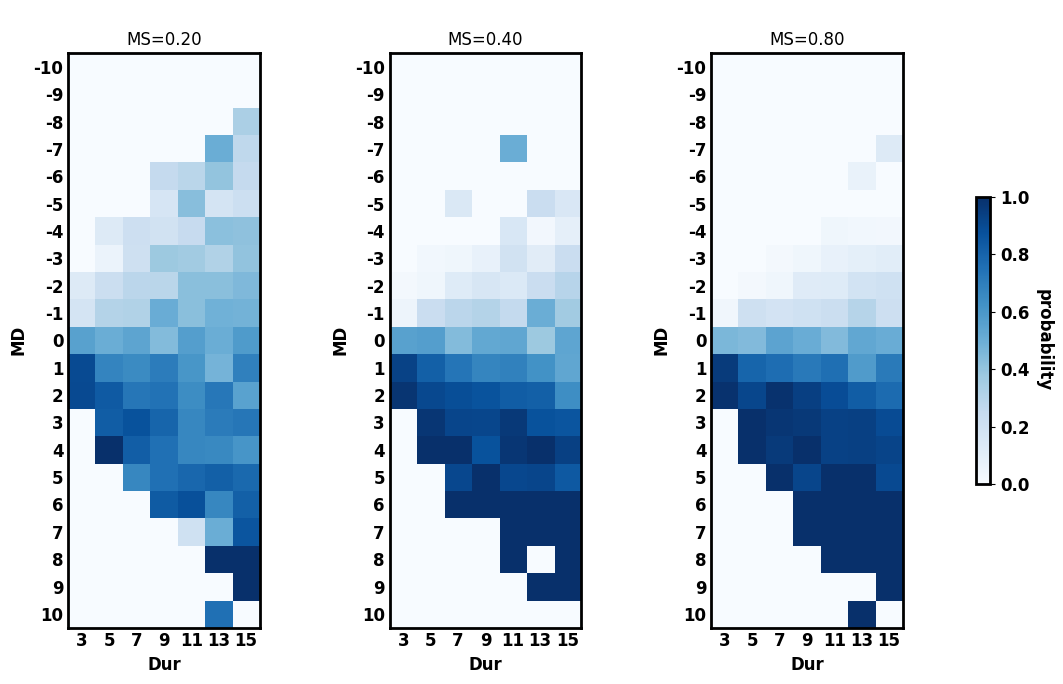

In [4]:
FG.plot_kernels(kernel=1, no_dist=True)

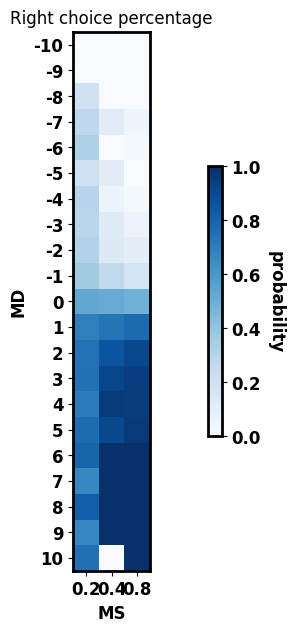

In [5]:
FG.plot_kernels(kernel=3, no_dist=True)

/home/wehe/tmp/NSC/codes/src/features/features.py:542: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


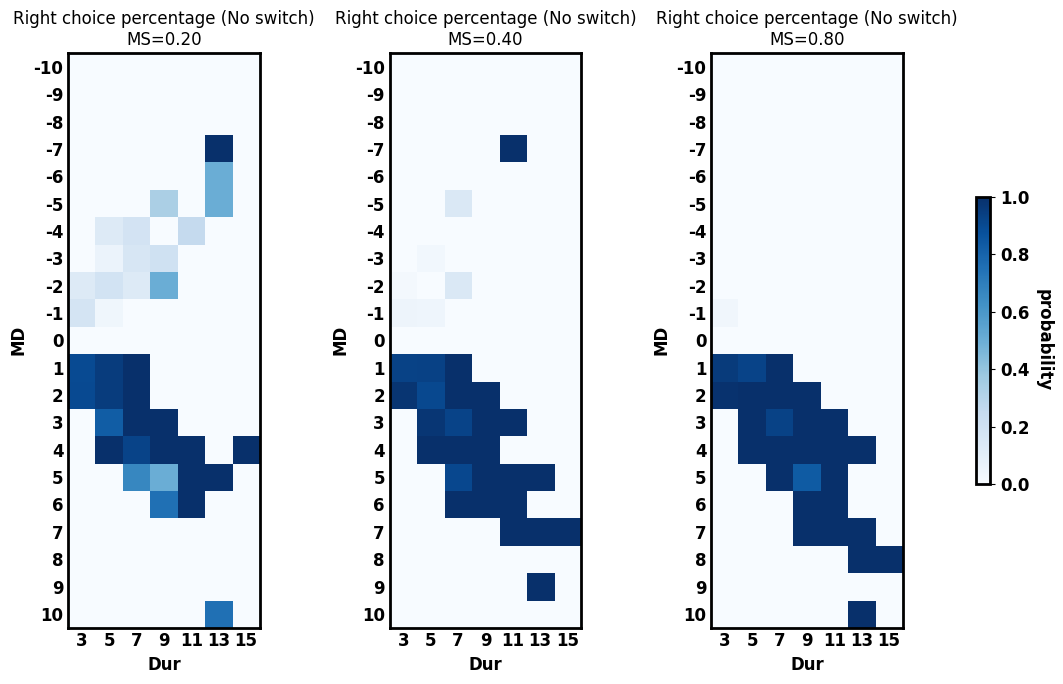

In [6]:
FG.plot_kernels(kernel=4, no_dist=True)

/home/wehe/tmp/NSC/codes/src/features/features.py:597: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


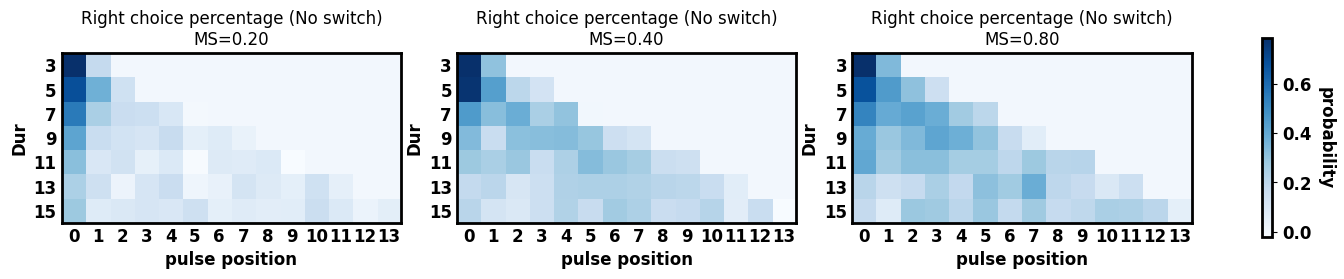

In [7]:
FG.plot_kernels(kernel=5, no_dist=True)

## Features

In [8]:
feature_1s, feature_2s, feature_3s, feature_4s, feature_5s = FG.get_features()
feature_5s_normed = convert_array_range(feature_5s, [-1, 1], [0, 1])
features = [feature_1s, feature_2s, feature_3s, feature_4s, feature_5s_normed]
# feature = FG.compute_kernels(seqC, chR, D, M, S).get_provided_feature(feature_list=[1,2,3,4,5])
feature_lens = [x.shape[1] for x in features]

feature = []
for i in range(M):
    for j in range(len(features)):
        feature.append(features[j][i])
feature = torch.cat(feature)
feature_lens

[69, 69, 15, 12, 56]

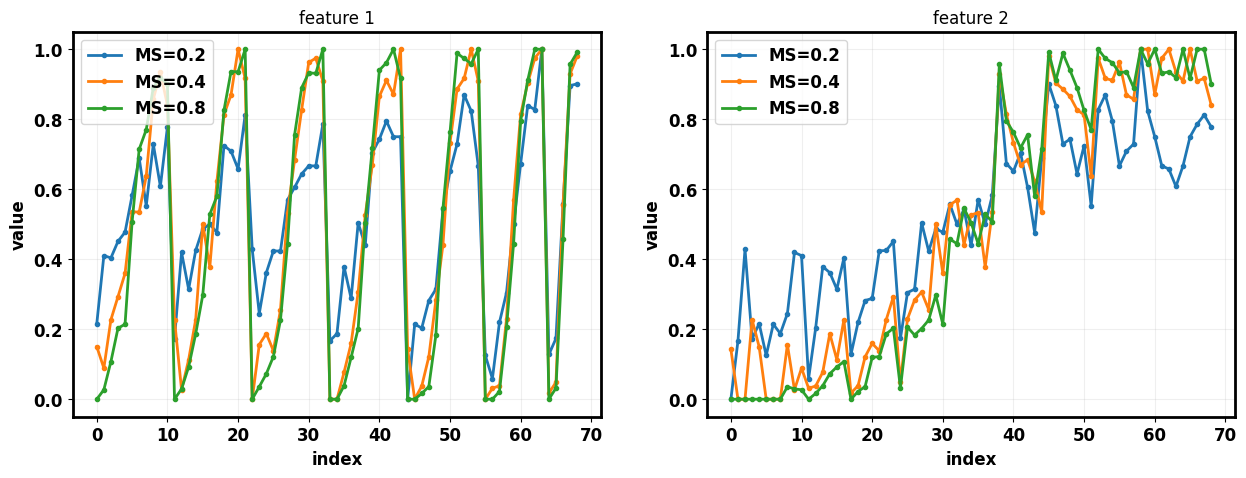

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = axes[0]
for i in range(M):
    ax.plot(feature_1s[i], ".-", label=f"MS={FG.MS_list[i]:.1f}", linewidth=2, color=colors[i])
ax.set_title("feature 1")
ax.set_xlabel("index")
ax.set_ylabel("value")

ax = axes[1]
for i in range(M):
    ax.plot(feature_2s[i], ".-", label=f"MS={FG.MS_list[i]:.1f}", linewidth=2, color=colors[i])
ax.set_title("feature 2")
ax.set_xlabel("index")
ax.set_ylabel("value")

for ax in axes:
    ax.grid(alpha=0.2)
    ax.legend()

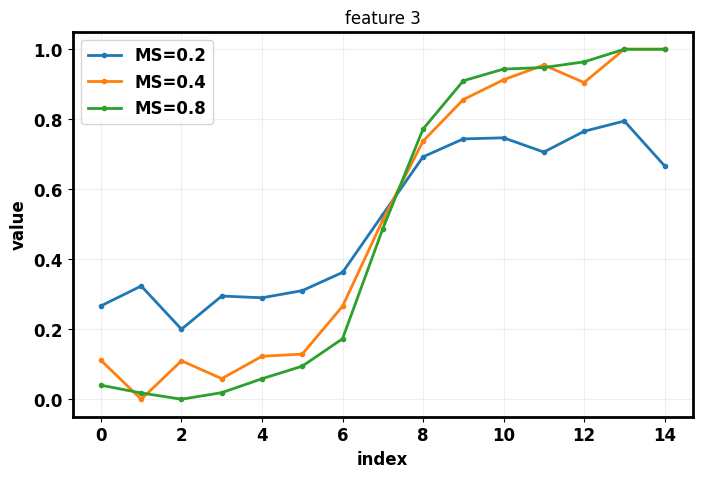

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
for i in range(M):
    ax.plot(feature_3s[i], ".-", label=f"MS={FG.MS_list[i]:.1f}", linewidth=2, color=colors[i])
ax.set_title("feature 3")
ax.set_xlabel("index")
ax.set_ylabel("value")
ax.grid(alpha=0.2)
ax.legend()

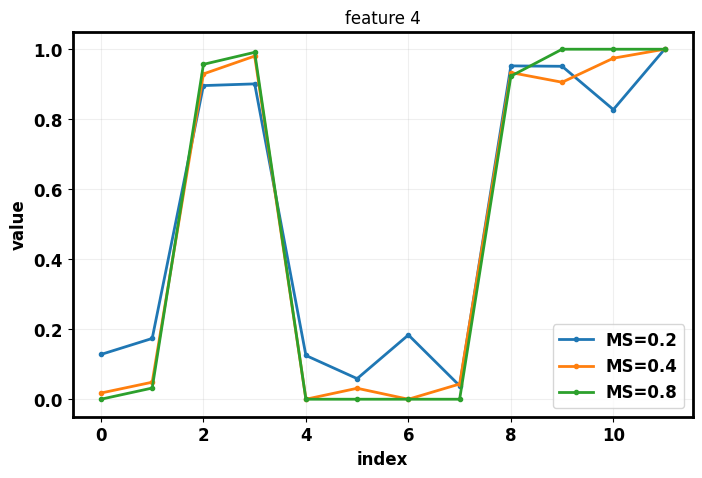

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
for i in range(M):
    ax.plot(feature_4s[i], ".-", label=f"MS={FG.MS_list[i]:.1f}", linewidth=2, color=colors[i])
ax.set_title("feature 4")
ax.set_xlabel("index")
ax.set_ylabel("value")
ax.grid(alpha=0.2)
ax.legend()

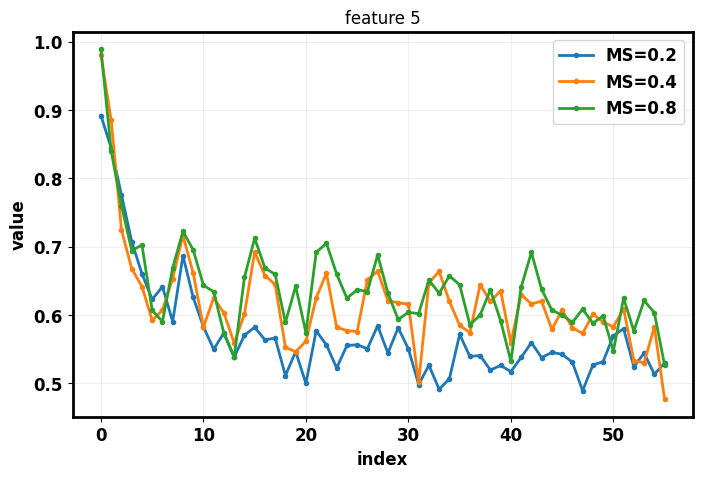

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
for i in range(M):
    ax.plot(feature_5s_normed[i], ".-", label=f"MS={FG.MS_list[i]:.1f}", linewidth=2, color=colors[i])
ax.set_title("feature 5")
ax.set_xlabel("index")
ax.set_ylabel("value")
ax.grid(alpha=0.2)
ax.legend()

In [13]:
pos=0
vline_poss = [0]
for i in range(M):
    for l in feature_lens:
        pos += l
        vline_poss.append(pos)
vM_poss = [0]
for i in range(M):
    vM_poss.append(sum(feature_lens)*(i+1))
# vline_poss = [acc+=l for l in feature_lens for i in range(M)]

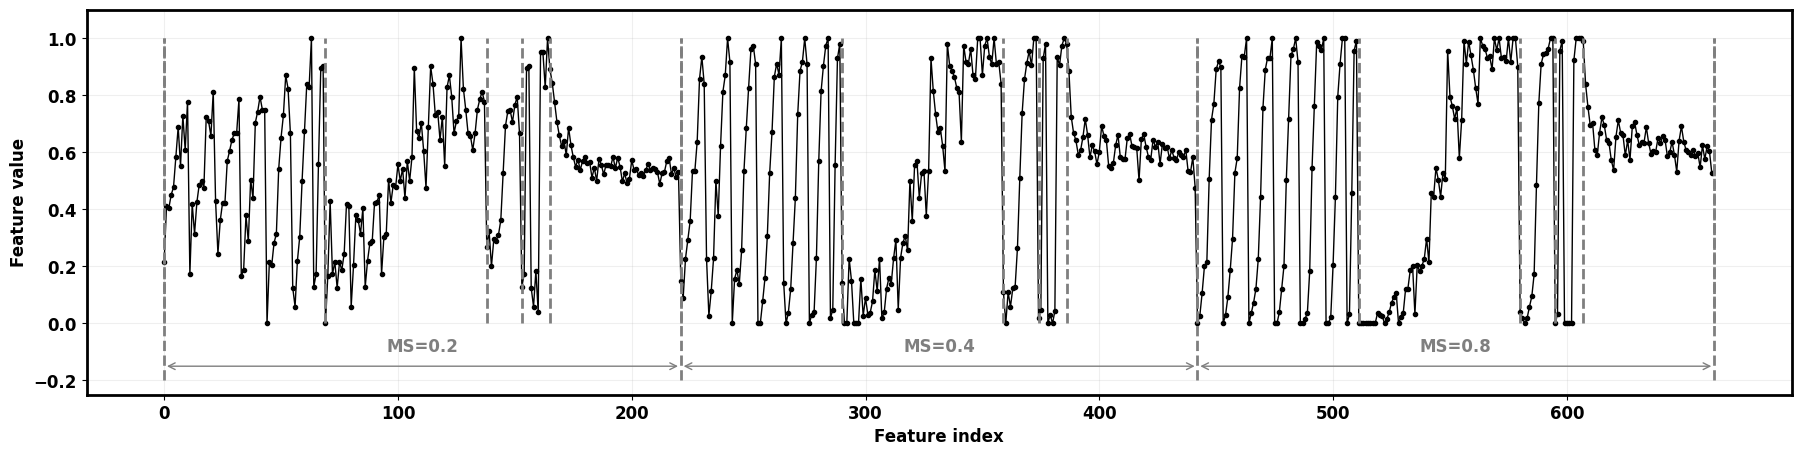

In [14]:
def plot_features(features, ax, vline_poss, vM_poss, color='k', label=""):
    ax.plot(features, ".-", color=color, linewidth=1, label=label)
    ax.vlines(vline_poss, 0, 1, color='tab:gray', linewidth=2, linestyle='--')
    ax.vlines(vM_poss, -0.2, 1, color='tab:gray', linewidth=2, linestyle='--')

    # ax.xlim(-10, vM_poss[-1]+10)
    # Adding arrows and text
    y_pos = -0.15 # Adjust this value based on where you want the text to appear
    for i in range(len(vM_poss) - 1):
        mid_point = (vM_poss[i] + vM_poss[i + 1]) / 2
        ax.text(mid_point, y_pos + 0.1, f'MS={0.2 * 2 ** i}', ha='center', va='top', color="tab:gray") # Text just below arrow
        ax.annotate("",
                    xy=(vM_poss[i], y_pos), xycoords='data',
                    xytext=(vM_poss[i + 1], y_pos), textcoords='data',
                    arrowprops=dict(arrowstyle="<->", color='tab:gray',
                                    connectionstyle="arc3"),
                    )

    ax.grid(alpha=0.2)
    ax.set_ylim(-0.25, 1.1)
    ax.set_xlabel("Feature index")
    ax.set_ylabel("Feature value")
    
    # y_pos = 1.15
    # f_counter = 0
    # for i in range(len(vline_poss) - 1):
    #     f_counter += 1
    #     if f_counter == 6:
    #         f_counter = 1
    #     mid_point = (vline_poss[i] + vline_poss[i + 1]) / 2
    #     plt.text(mid_point, y_pos + 0.1, f'F{f_counter}', ha='center', va='top') # Text just below arrow
    #     plt.annotate("",
    #                  xy=(vline_poss[i], y_pos), xycoords='data',
    #                  xytext=(vline_poss[i + 1], y_pos), textcoords='data',
    #                  arrowprops=dict(arrowstyle="<->", color='tab:blue',
    #                                  connectionstyle="arc3"),
    #                  )

fig, ax = plt.subplots(1, 1, figsize=(22, 5))
plot_features(feature, ax, vline_poss, vM_poss)

## Prepared Dataset 

In [15]:
feature_dir = Path(NSC_DIR) / "data/dataset/feature-L0-Eset0-100sets-T500-C100.h5"
# load the file
f = h5py.File(feature_dir, "r")
# get the keys
sets = list(f.keys())
T, C, M, _ = f[sets[0]][f"feature_{1}"].shape

features_collection = []
set_idxs = [0,  0, 1, 1, 10]
T_idxs   = [0,  0, 0, 1, 6]
C_idxs   = [0, 10, 0, 0, 0]

set_idxs = [0,  0, 0, ]
T_idxs   = [0,  0, 1, ]
C_idxs   = [0, 10, 0, ]

for i in range(len(set_idxs)):
    set_idx, T_idx, C_idx = set_idxs[i], T_idxs[i], C_idxs[i]
    data_collection = []
    for F_idx in range(1, 6):
        data = f[sets[set_idx]][f"feature_{F_idx}"][T_idx, C_idx]
        if F_idx ==5:
            data = convert_array_range(data, original_range=[-1, 1], dest_range=[0, 1])
        data_collection.append(data)
    data_collection = np.concatenate(data_collection, axis=-1).reshape(-1)
    features_collection.append(data_collection)

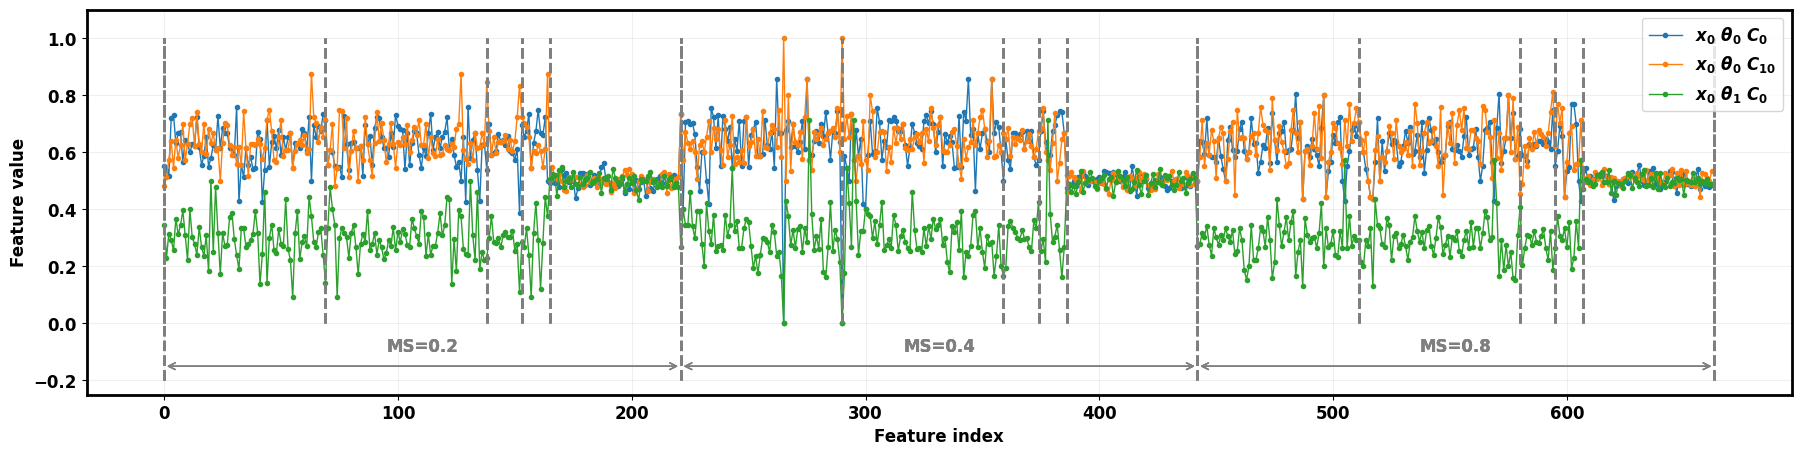

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(22, 5))
for i in range(len(set_idxs)):
    theta_ = rf"$\theta_{T_idxs[i]}$"
    ch_ = r"$C_{" + f"{C_idxs[i]}" + r"}$"
    label = f"$x_{set_idxs[i]}$ {theta_} {ch_}"
    plot_features(features_collection[i], ax, vline_poss, vM_poss, color=colors[i], label=label)
ax.legend()

## load training data

In [17]:
# %% ==================================================
pipeline_version = "p4a"
train_id = "train_L0_p4a"
exp_id = "p4a-F134-cnn-maf3-tmp"

# %% ========== load the latest event file
log_dir = Path(NSC_DIR) / "codes/src/train/logs" / train_id / exp_id
(
    wall_time,
    step_nums,
    learning_rates,
    log_probs_train,
    log_probs_valid,
) = get_train_valid_lr(log_dir)

all_probs = np.concatenate([log_probs_train, log_probs_valid])
upper = np.max(all_probs)
lower = np.percentile(all_probs, 10)

# %% ========== load the config.yaml file
config_file = log_dir / "config.yaml"
config = adapt_path(config_file)

with open(config, "r") as f:
    config = yaml.safe_load(f)

prior_min = config["prior"]["prior_min"]
prior_max = config["prior"]["prior_max"]
# prior_labels = config["prior"]["prior_labels"]
prior_labels = ["$b$", "$\sigma^2_a$", "$\sigma^2_s$", "$\lambda$"]

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['train_loss_batch', 'learning_rates'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['log_probs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['log_probs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


## training curve

Text(0.5, 0, 'time (hours)')

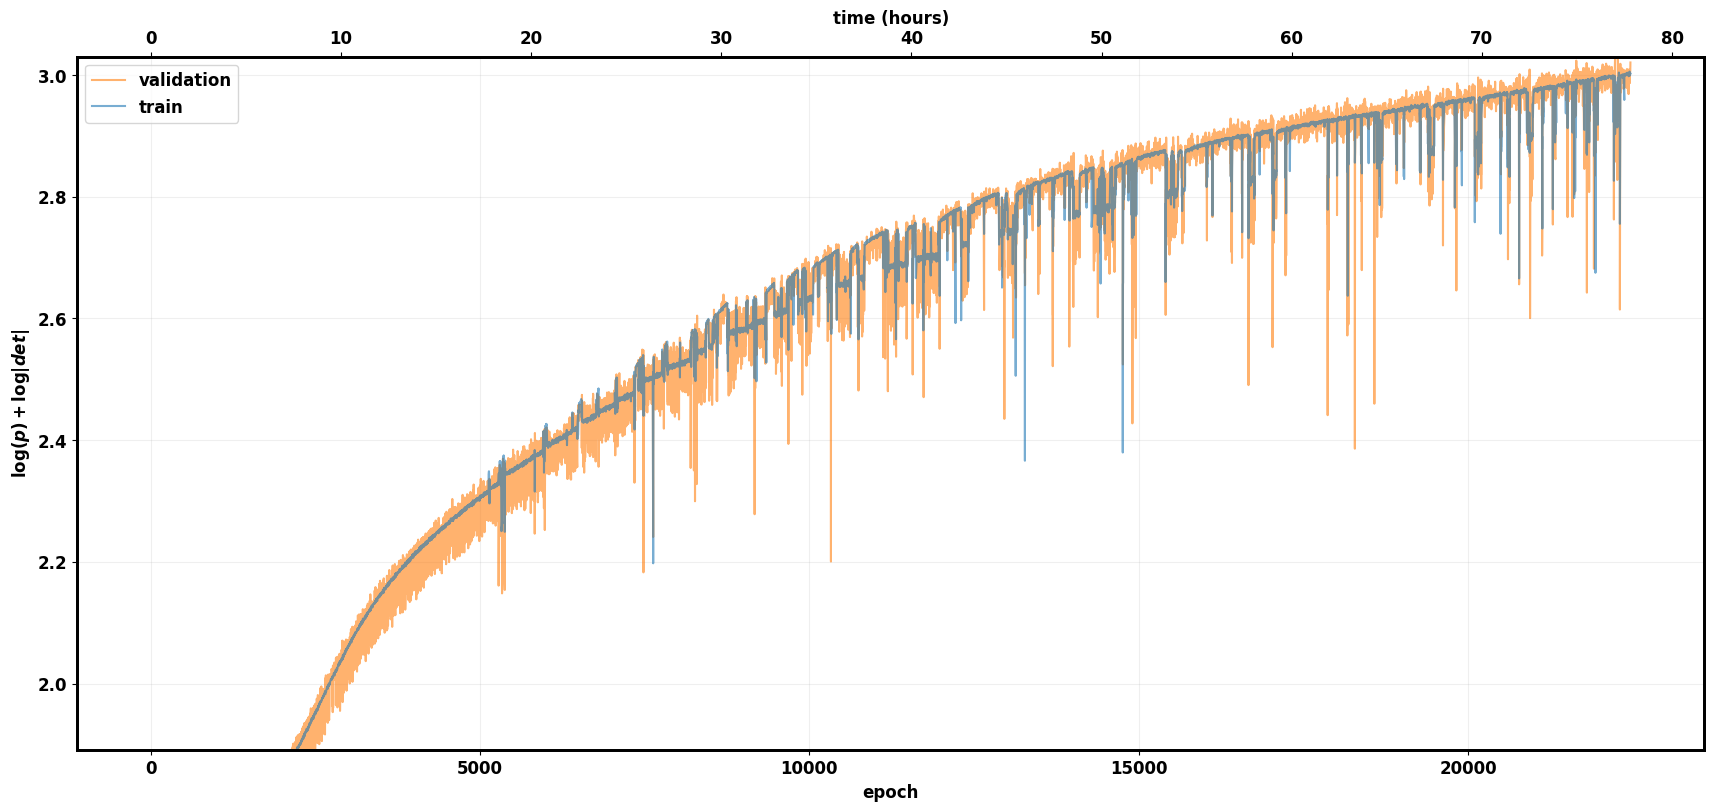

In [18]:
# %% ========== plot training curves
fig, ax = plt.subplots(figsize=(21, 9))
ax.plot(step_nums, log_probs_valid, label="validation", alpha=0.6, ms=0.2, color=colors[1])
ax.plot(step_nums, log_probs_train, label="train", alpha=0.6, ms=0.2, color=colors[0])
ax.set_ylim(lower, upper)
ax.set_xlabel("epoch")
ax.set_ylabel("$\log(p)+\log|det|$")
ax.grid(alpha=0.2)
ax.legend()

ax1 = ax.twiny()
ax1.plot(
    (np.array(wall_time) - wall_time[0]) / 60 / 60,
    max(log_probs_valid) * np.ones_like(log_probs_valid),
    "-",
    alpha=0,
)
ax1.set_xlabel("time (hours)")

## Training Progress

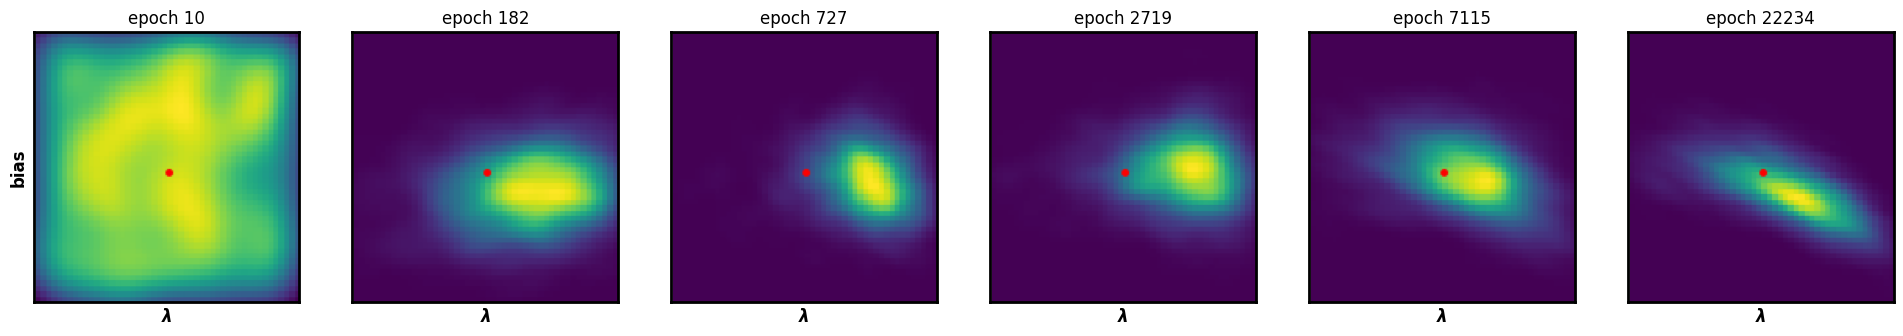

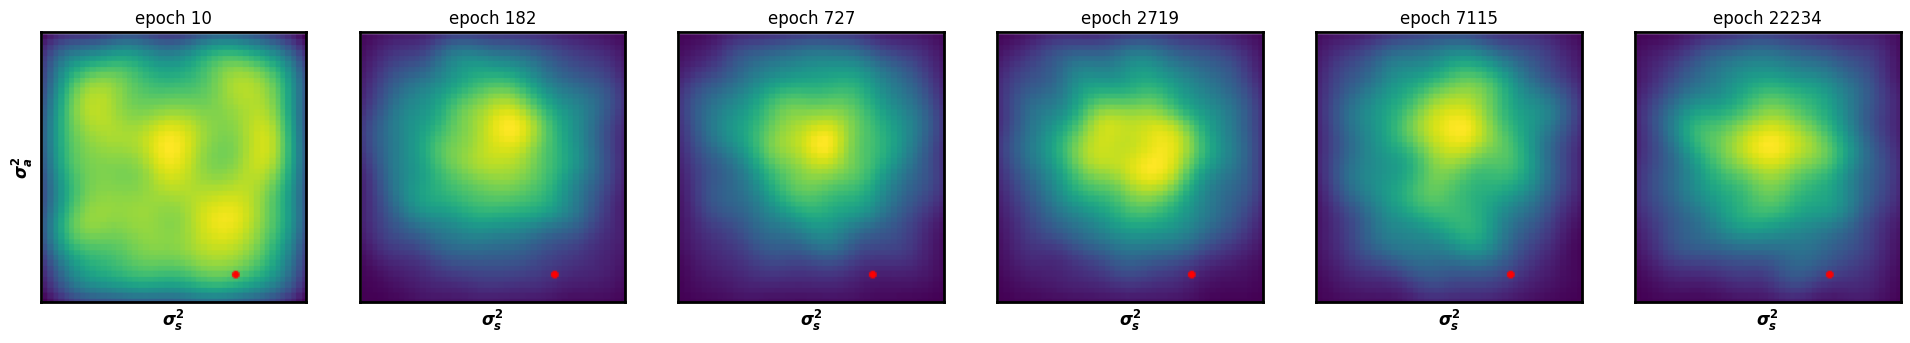

In [19]:
# %% ========== plot posterior training process
num_epoch = 6
best_epoch = step_nums[np.argmax(log_probs_valid)]

# get recorded posterior plot names
img_folder = Path(f"{log_dir}/posterior/figures")
posterior_plots = img_folder.glob("posterior_seen_0*.png")
posterior_idx = [eval(str(plot).split("epoch_")[-1].split(".png")[0]) for plot in posterior_plots]
posterior_idx = np.array(posterior_idx)[np.argsort(posterior_idx)]

chosen_idx = np.linspace(10, len(posterior_idx) - 1, num_epoch, dtype=int)

BL_coor = [731, 731 + 170, 99, 99 + 173]  # x_start, x_end, y_start, y_end
BL_labels = ["$\lambda$", "bias"]
AS_coor = [528, 528 + 170, 304, 304 + 173]  # x_start, x_end, y_start, y_end
AS_labels = ["$\sigma^2_s$", "$\sigma^2_a$"]

coor = BL_coor
labels = BL_labels

# coor = AS_coor
# labels = AS_labels
fig, axes = plt.subplots(1, num_epoch, figsize=(num_epoch * 4, 4))
for i, epoch_idx in enumerate(chosen_idx):
    ax = axes[i]
    img_path = img_folder / f"posterior_seen_0_epoch_{posterior_idx[epoch_idx]}.png"
    if img_path.exists():
        load_img(
            img_path=img_path,
            ax=ax,
            title=f"epoch {posterior_idx[epoch_idx]}",
            crop=True,
            x_start=coor[0],
            x_end=coor[1],
            y_start=coor[2],
            y_end=coor[3],
        )
    ax.set_xlabel(labels[0])
    if i == 0:
        ax.set_ylabel(labels[1])

coor = AS_coor
labels = AS_labels
fig, axes = plt.subplots(1, num_epoch, figsize=(num_epoch * 4, 4))
for i, epoch_idx in enumerate(chosen_idx):
    ax = axes[i]
    img_path = img_folder / f"posterior_seen_0_epoch_{posterior_idx[epoch_idx]}.png"
    if img_path.exists():
        load_img(
            img_path=img_path,
            ax=ax,
            title=f"epoch {posterior_idx[epoch_idx]}",
            crop=True,
            x_start=coor[0],
            x_end=coor[1],
            y_start=coor[2],
            y_end=coor[3],
        )
    ax.set_xlabel(labels[0])
    if i == 0:
        ax.set_ylabel(labels[1])

## Load posterior samples 

In [20]:
# %% ==========  get posterior samples
config, model_path = load_stored_config(exp_dir=log_dir)

if "p4" in pipeline_version:
    from train.train_L0_p4a import Solver
if "p5" in pipeline_version:
    from train.train_L0_p5a import Solver

solver, posterior, train_loader, valid_loader, train_dataset, valid_dataset = get_posterior(
    model_path=model_path,
    config=config,
    device="cuda",
    Solver=Solver,
    low_batch=20,
    return_dataset=True,
)

==>> config_path: /home/wehe/tmp/NSC/codes/src/train/logs/train_L0_p4a/p4a-F134-cnn-maf3-tmp/config.yaml
using device: cuda

--- CUDA info ---
NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
--- CUDA info ---



/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


prior min before norm: [-2.5, 0, 0, -11]
prior max before norm: [2.5, 77, 18, 10]
prior min: [0. 0. 0. 0.]
prior max: [1. 1. 1. 1.]

=== embedding net === 
cnn

=== train, val dataset and dataloader ===
train_set_names=['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24']
valid_set_names=['set_25', 'set_26']
[training] sets len_feature_each_type=[69, 15, 12]
loading 18sets T100.00% C25...


100%|██████████| 18/18 [00:00<00:00, 73.80it/s]


dataset info: ==> self.total_samples=225000 => self.x.shape=torch.Size([18, 500, 25, 288, 1]) self.theta.shape=torch.Size([18, 500, 4])

[validation] sets len_feature_each_type=[69, 15, 12]
loading 2sets T100.00% C25...


100%|██████████| 2/2 [00:00<00:00, 88.08it/s]

dataset info: ==> self.total_samples=25000 => self.x.shape=torch.Size([2, 500, 25, 288, 1]) self.theta.shape=torch.Size([2, 500, 4])
loader_kwargs={'batch_size': 20, 'drop_last': False, 'shuffle': True, 'pin_memory': False, 'num_workers': 4, 'worker_init_fn': <function seed_worker at 0x7fb85cd0b880>, 'prefetch_factor': 2}

collect posterior sets... 

takes 0.48 seconds = 0.01 minutes

finished build network
Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=128, bias=True)
          (context_layer): Linear(in_features=256, out_features=128, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=128, out_features=8, bias=True)
        )
      )
      (1): RandomPermutation()
      (2): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=128, bias=True)
          (context_layer): Linear(in_features=256, out_features=128, bias=True)

In [21]:
normed_limits = solver._get_limits()
designed_limits = get_limits(config.prior.prior_min, config.prior.prior_max)

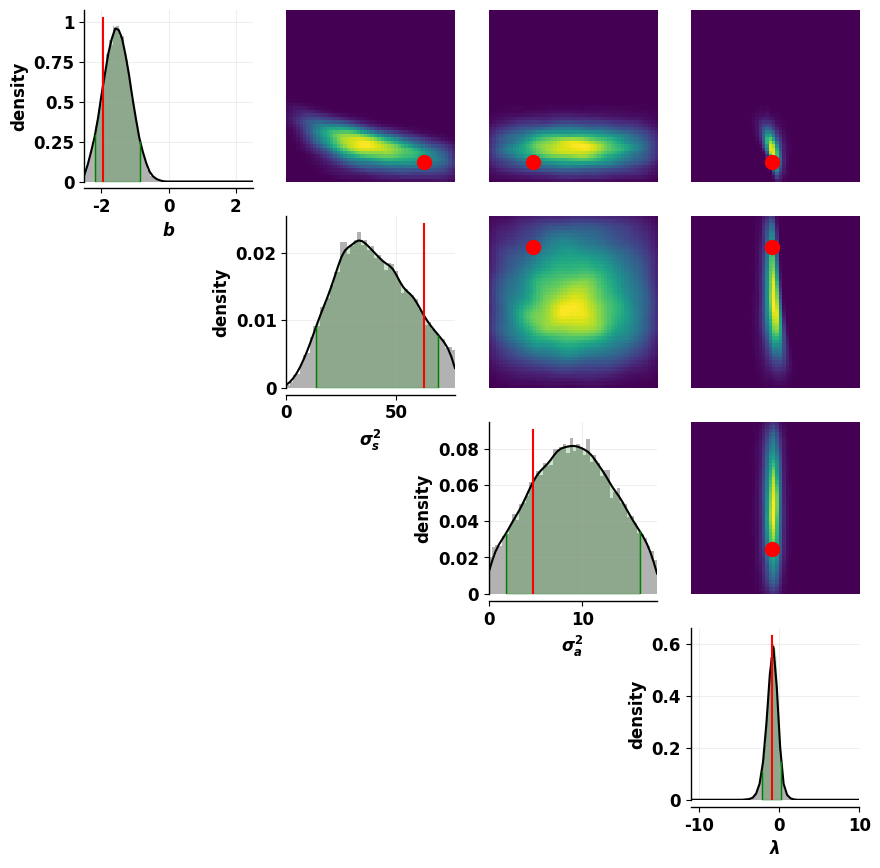

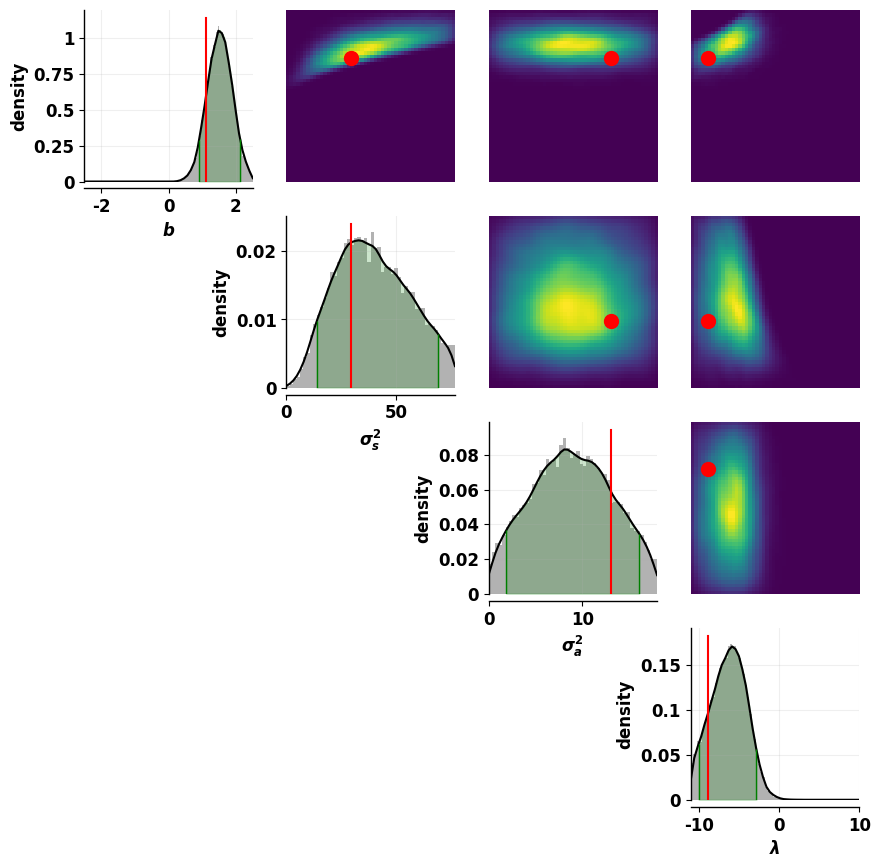

In [23]:
# %% load one sample - training sample
# seen_data = solver.inference.seen_data_for_posterior
f_o, true_theta = train_dataset[1]

fig, ax, samples = plot_posterior_mapped_samples(
    posterior,
    f_o,
    true_theta=true_theta,
    num_samples=20_000,
    sampling_device="cuda",
    show_progress_bars=False,
    original_limits=normed_limits,
    mapped_limits=designed_limits,
)

f_o, true_theta = valid_dataset[1]
fig, ax, samples = plot_posterior_mapped_samples(
    posterior,
    f_o,
    true_theta=true_theta,
    num_samples=20_000,
    sampling_device="cuda",
    show_progress_bars=False,
    original_limits=normed_limits,
    mapped_limits=designed_limits,
)

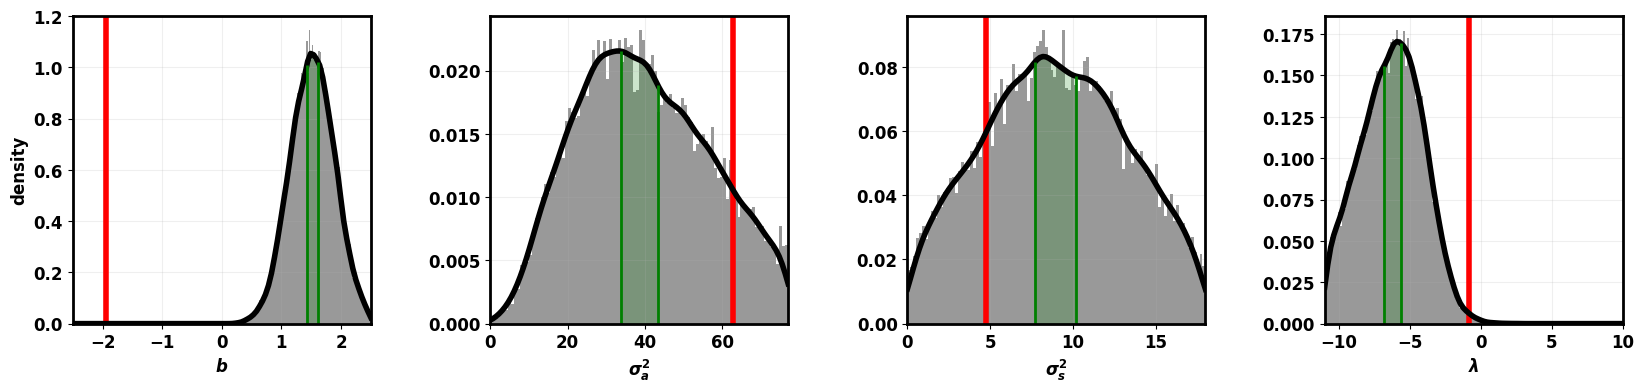

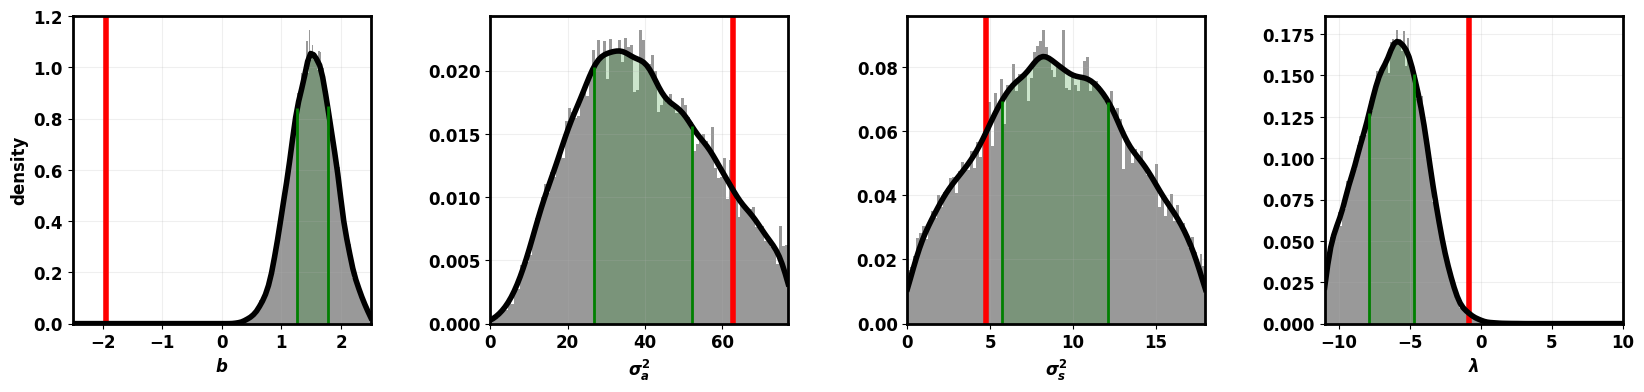

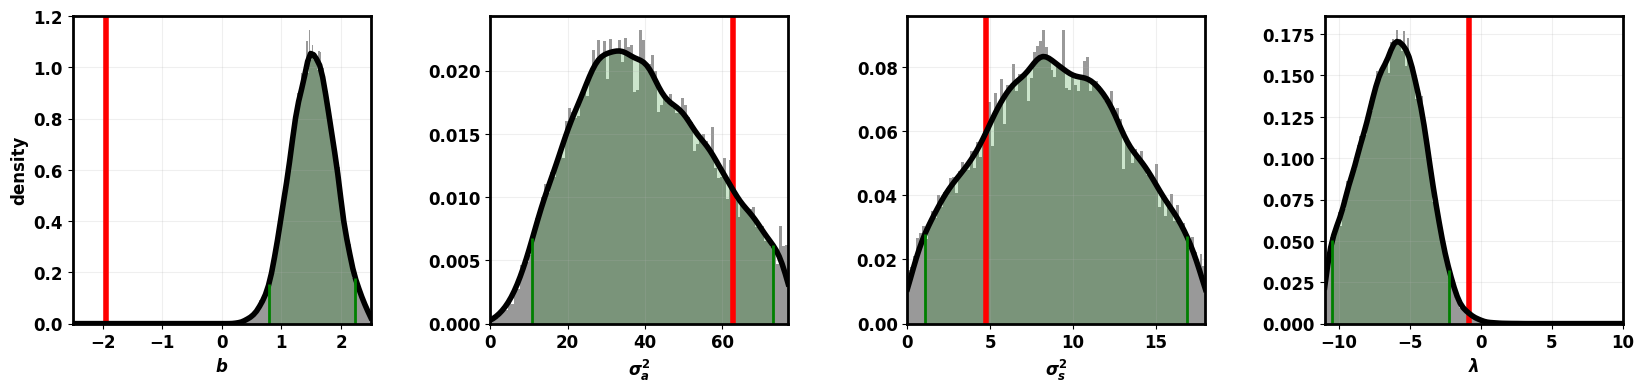

In [24]:
credible_intervals = [20, 50, 95]
for credible_interval in credible_intervals:
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    fig.subplots_adjust(wspace=0.4)
    true_theta_dr = convert_samples_range(true_theta, normed_limits, designed_limits)
    axes = marginal_plot(
        samples,
        true_theta_dr,
        origin_limits=designed_limits,
        dest_limits=designed_limits,
        credible_interval=credible_interval,
        axes=axes,
    )
    for i in range(len(axes)):
        axes[i].set_xlabel(prior_labels[i])

## change one of the parameter and see how the prediction changes

prepare the changing theta values

In [141]:
# prepare varying theta values
print(f"{designed_limits=}")
ref_theta_values = [1, 10, 10, 1]

step = 7
theta_values = np.ones((4 * step, 4))
for i in range(len(ref_theta_values)):
    theta_values[:, i] = ref_theta_values[i]

for i, limits in enumerate(designed_limits):
    values = np.linspace(limits[0], limits[1], step)
    theta_values[i * step : (i + 1) * step, i] = values

print(f"==>> theta_values: {theta_values}")    

designed_limits=[[-2.5, 2.5], [0, 77], [0, 18], [-11, 10]]
==>> theta_values: [[ -2.5         10.          10.           1.        ]
 [ -1.66666667  10.          10.           1.        ]
 [ -0.83333333  10.          10.           1.        ]
 [  0.          10.          10.           1.        ]
 [  0.83333333  10.          10.           1.        ]
 [  1.66666667  10.          10.           1.        ]
 [  2.5         10.          10.           1.        ]
 [  1.           0.          10.           1.        ]
 [  1.          12.83333333  10.           1.        ]
 [  1.          25.66666667  10.           1.        ]
 [  1.          38.5         10.           1.        ]
 [  1.          51.33333333  10.           1.        ]
 [  1.          64.16666667  10.           1.        ]
 [  1.          77.          10.           1.        ]
 [  1.          10.           0.           1.        ]
 [  1.          10.           3.           1.        ]
 [  1.          10.           6.          

prepare unseen valid data from 'set_25'

In [142]:
# prepare the seqC_o from unseen dataset ['set_25']
f = h5py.File(DATA_PATH, "r")
f.keys()
seqC = f['set_25']['seqC'][:]
f.close()
print(f"==>> seqC.shape: {seqC.shape}")
print(f'{seqC[0,0,:5,:]=}')
D, M, S = seqC.shape[0], seqC.shape[1], seqC.shape[2]
DMS = D * M * S

==>> seqC.shape: (7, 3, 700, 15)
seqC[0,0,:5,:]=array([[ 0. ,  0. , -0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ 0. ,  0. , -0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ 0. , -0.2,  0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ 0. , -0.2, -0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ 0. ,  0.2, -0.2,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan]])


run the simulator -> get probR -> sample into chR: </br>

In [143]:
# run the simulator
params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
    seqCs=seqC,
    prior=theta_values,
    num_workers=16,
    privided_prior=True,
)


--- simulating pR with... ---
prior sample size: 1
model_name: B-G-L0S-O-N-
total number of simulations 411600 with 16 workers ...



/tmp/ipykernel_151005/2629399163.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 865 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done 35328 tasks      | elapsed:    5.4s
[Parallel(n_jobs=16)]: Done 124928 tasks      | elapsed:    9.2s
[Parallel(n_jobs=16)]: Done 240128 tasks      | elapsed:   14.6s
[Parallel(n_jobs=16)]: Done 380928 tasks      | elapsed:   21.7s


time elapsed for simulation: 0.39 minutes
stacking the results
done stacking the results

seqC.shape: (7, 3, 700, 15), params.shape: (28, 4), probR.shape: (7, 3, 700, 28, 1)


[Parallel(n_jobs=16)]: Done 411600 out of 411600 | elapsed:   23.6s finished


In [144]:
# bernoulli sampling using pytorch
chRs = torch.from_numpy(probR).repeat_interleave(10, dim=-1)
chRs = torch.bernoulli(chRs)
print(f"==>> chR.shape: {chRs.shape}")

==>> chR.shape: torch.Size([7, 3, 700, 28, 10])


extract feature from seqC+chR

In [145]:
def feature_extraction(seqC, chR, config):
    if not isinstance(seqC, torch.Tensor):
        seqC = torch.from_numpy(seqC)

    # compute all features
    D,M,S = seqC.shape[:-1]
    features = FG.compute_kernels(seqC, chR, D, M, S).get_features()
    
    # concatenate selected features
    chosen_feature_data = []
    for i in config.dataset.concatenate_feature_types:
        feature_data = features[i-1]
        if i == 5:
            # mapping F5
            feature_data = convert_array_range(feature_data, [-1, 1], [0, 1])
        chosen_feature_data.append(feature_data)
    concatenated_features = torch.cat(chosen_feature_data, dim=-1)

    # concatenate along M
    if config.dataset.concatenate_along_M:
        concatenated_features = concatenated_features.view(M * n_features)
        
    return concatenated_features

In [146]:
chosen_features_lens = config.dataset.feature_lengths
n_features = sum(chosen_features_lens)
print(f"==>> n_features: {n_features*M}")

==>> n_features: 288


In [147]:
T_idx = 0
C_idx = 0
nT = theta_values.shape[0]
Fs = torch.zeros((nT, n_features * M))

for T_idx in tqdm(range(nT)):
    chR = chRs[:, :, :, T_idx, C_idx].unsqueeze(-1)
    F = feature_extraction(seqC, chR, config)
    Fs[T_idx] = F

print(f"==>> Fs.shape: {Fs.shape}")

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:17<00:00,  1.57it/s]

==>> Fs.shape: torch.Size([28, 288])


In [155]:
num_params = len(prior_labels)
all_samples = np.zeros((4, step - 2, 20_000, 4))
all_thetas = np.zeros((4, step - 2, 4))

for T in range(nT):
    if T % step == 0 or T % step == step - 1:
        continue

    moving_theta_idx = T // step
    trial_idx = T % step - 1

    theta_test = torch.tensor(theta_values[T, :])
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    
    F_test = Fs[T, :].unsqueeze(0).unsqueeze(-1).cuda()

    samples = sampling_from_posterior(
        "cuda",
        posterior,
        F_test,
        num_samples=20_000,
        show_progress_bars=False,
    )
    all_samples[moving_theta_idx, trial_idx, :, :] = samples
    all_thetas[moving_theta_idx, trial_idx, :] = theta_test

all_samples_dr = convert_samples_range(all_samples, normed_limits, designed_limits)
all_thetas_dr = convert_samples_range(all_thetas, normed_limits, designed_limits)

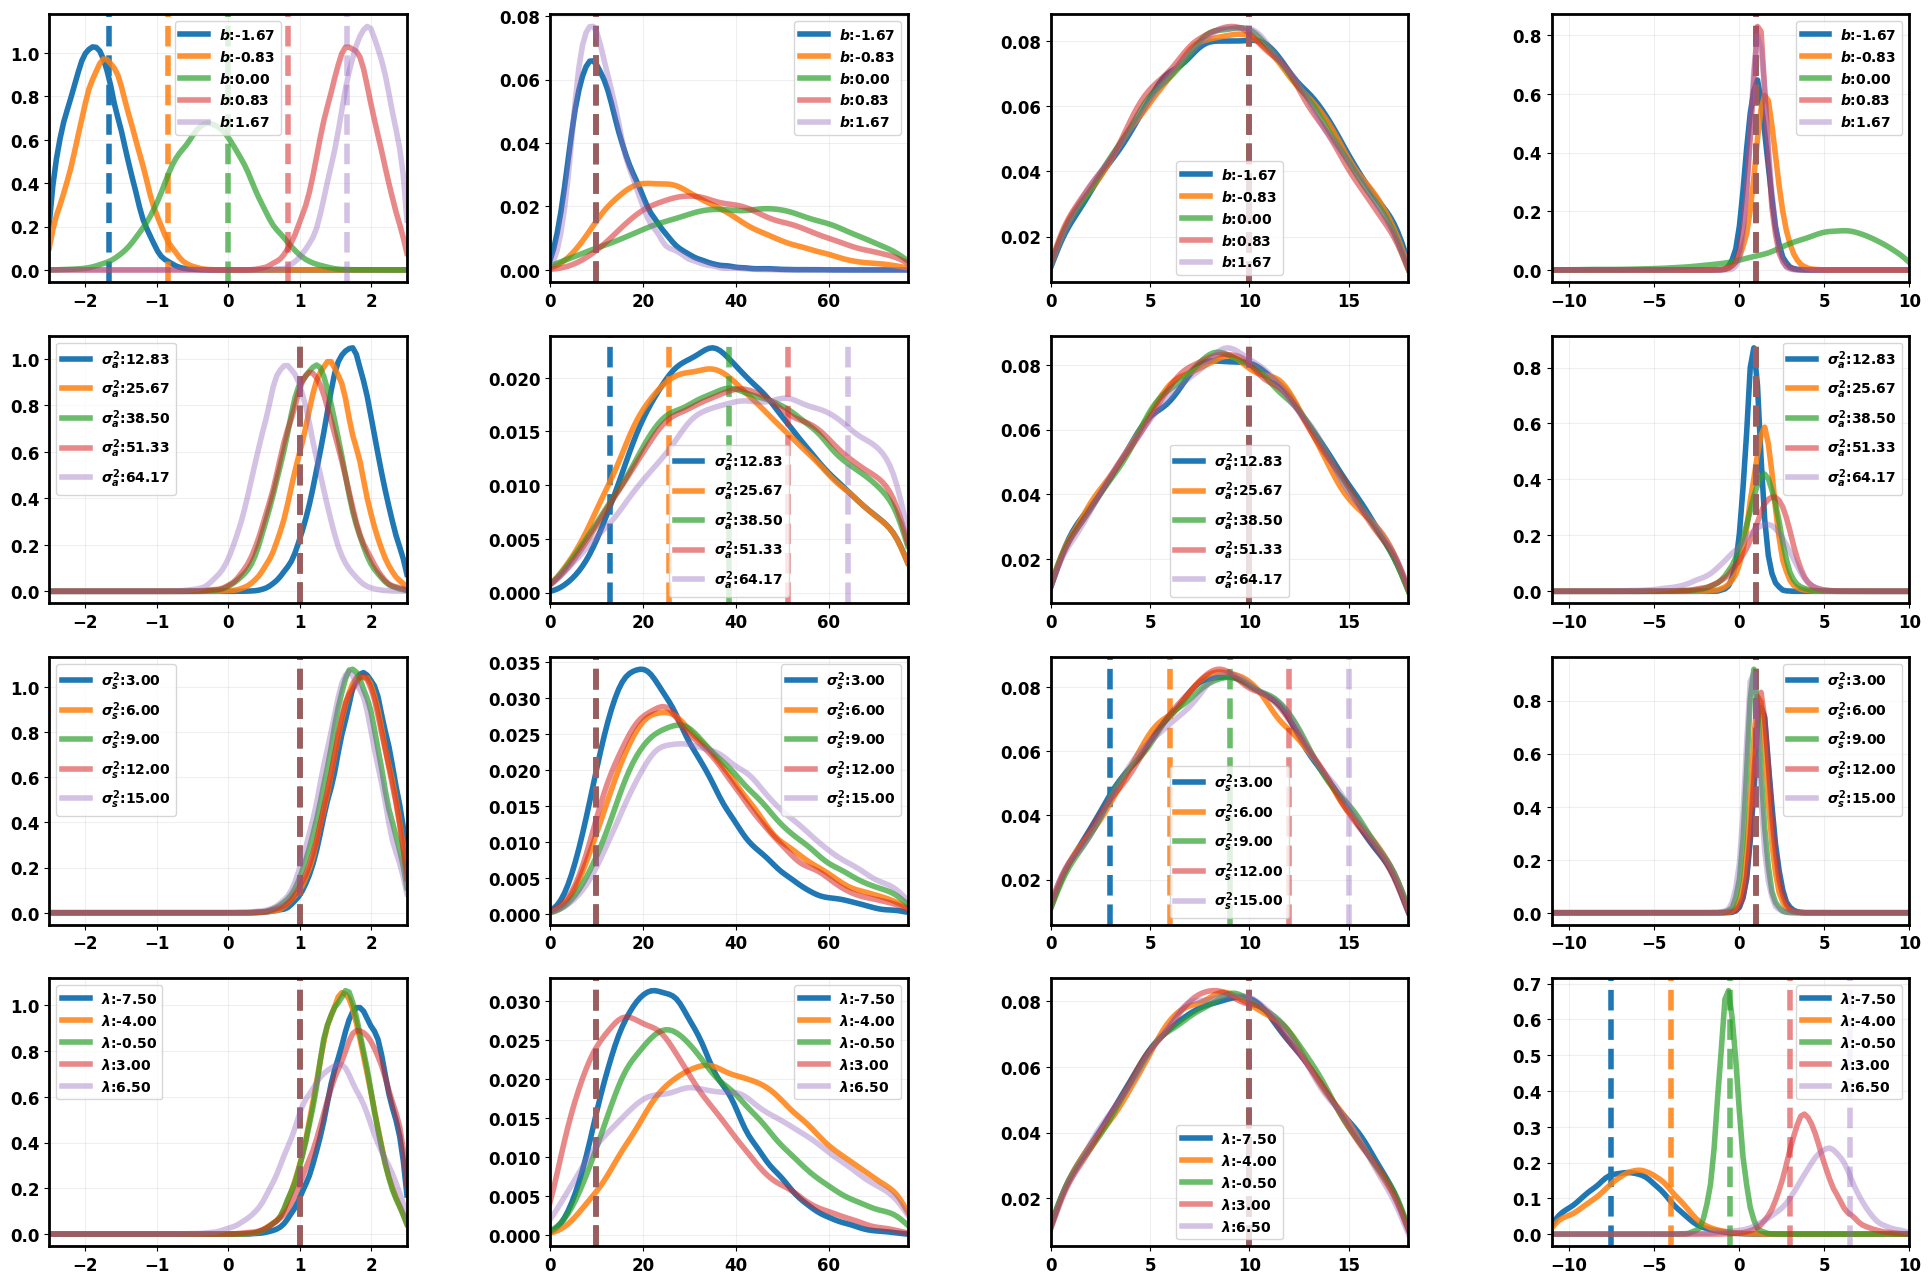

In [158]:
fig, axes = plt.subplots(
    all_thetas_dr.shape[0],
    all_thetas_dr.shape[-1],
    figsize=(all_thetas_dr.shape[-1] * 6, 4 * all_thetas_dr.shape[0]),
)
fig.subplots_adjust(wspace=0.4)
num_trials = all_thetas_dr.shape[1]

dest_limits = designed_limits

for i in range(all_thetas_dr.shape[0]):
    ax_row = axes[i, :]
    samples_row = all_samples_dr[i]
    moving_theta_idx = i

    for j in range(num_params):
        for k in range(num_trials):
            ax = ax_row[j]
            # density estimation
            density = gaussian_kde(samples_row[k, :, j], bw_method="scott")
            xs = np.linspace(dest_limits[j][0], dest_limits[j][1], 100)
            ys = density(xs)
            # plot kde
            ax.plot(
                xs,
                ys,
                color=colors[k],
                linewidth=4,
                label=f"{prior_labels[i]}:{all_thetas_dr[i, k, i]:.2f}",
                alpha=1 - 0.6 * k / (num_trials - 1),
            )
            ax.set_xlim(dest_limits[j][0], dest_limits[j][1])
            ax.legend(fontsize=10)
            # 
            ax.axvline(
                all_thetas_dr[i, k, j],
                color=colors[k],
                linestyle="--",
                linewidth=4,
                alpha=1 - 0.6 * k / (num_trials - 1),
            )
            ax.grid(alpha=0.2)

参数分布

## Evaluate the performance of the trained model